# Poisson in 1D with scikit-fem

We solve the boundary value problem
$$-u''(x)=1,\quad x\in(0,1),\qquad u(0)=u(1)=0.$$

**Exact solution:** $u(x)=\tfrac{1}{2}x(1-x)$.
We use a P1 (linear) finite element discretization on a uniform 1D mesh.

## Step 1: Import Required Libraries

We start by importing the necessary libraries:
- `numpy` for numerical operations
- `matplotlib` for plotting
- `skfem` components for finite element computations
- `skfem.helpers` provides decorators and functions for defining variational forms

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skfem as fem
from skfem.helpers import *

## Step 2: Define Mesh and Function Space

Here we create the computational domain and finite element space:
- `MeshLine` creates a 1D mesh on the interval [0,1]
- `ElementLineP1` defines linear (P1) finite elements
- `Basis` combines the mesh and element to create the function space

We use a simple mesh with 5 intervals (6 nodes) for educational purposes.

In [18]:
# Mesh and basis on [0, 1]
n_intervals = 5   # 5 elements, 6 nodes
mesh = fem.MeshLine(np.linspace(0, 1, n_intervals + 1))
V = fem.Basis(mesh, fem.ElementLineP1())

## Step 3: Define Weak Form (Variational Formulation)

The weak form of our PDE $-u'' = 1$ is: Find $u$ such that
$$\int_0^1 u' v' \, dx = \int_0^1 1 \cdot v \, dx \quad \forall v$$

We define:
- **Bilinear form** (LHS): $a(u,v) = \int \nabla u \cdot \nabla v \, dx$
- **Linear form** (RHS): $L(v) = \int f \cdot v \, dx$ where $f=1$

The `@fem.BilinearForm` and `@fem.LinearForm` decorators create functions that can be assembled into matrices.

In [19]:
# Define bilinear form: ∫ ∇u · ∇v dx
@fem.BilinearForm
def a(u, v, _):
    return dot(grad(u), grad(v))  # In 1D, grad is just du/dx

# Define linear form: ∫ f * v dx (where f = 1)
@fem.LinearForm  
def L(v, _):
    return 1.0 * v

## Step 4: Assembly

The `asm()` function assembles the variational forms into:
- **Stiffness matrix** `A`: represents the bilinear form
- **Load vector** `b`: represents the linear form

This creates the linear system $Au = b$ that approximates our PDE.

In [20]:
# Assemble stiffness and load for -u'' = 1
A = a.assemble(V)
b = L.assemble(V)

print(f"System size: {A.shape[0]} x {A.shape[1]}")
print(f"Matrix type: {type(A)}")
print("\nStiffness matrix A:")
print(A.toarray())
print("\nLoad vector b:")
print(b)

System size: 6 x 6
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>

Stiffness matrix A:
[[ 5. -5.  0.  0.  0.  0.]
 [-5. 10. -5.  0.  0.  0.]
 [ 0. -5. 10. -5.  0.  0.]
 [ 0.  0. -5. 10. -5.  0.]
 [ 0.  0.  0. -5. 10. -5.]
 [ 0.  0.  0.  0. -5.  5.]]

Load vector b:
[0.1 0.2 0.2 0.2 0.2 0.1]


## Step 5: Apply Boundary Conditions and Solve

We enforce Dirichlet boundary conditions $u(0) = u(1) = 0$ by:
1. Finding boundary nodes (at x=0 and x=1)
2. Modifying the system: set boundary rows to identity, RHS to zero
3. Converting sparse matrix to dense for `np.linalg.solve()`
4. Solving the linear system

This is called the "elimination method" for applying essential boundary conditions.

In [21]:
# Find boundary nodes (x=0 and x=1)
x = mesh.p[0]
boundary = np.where((np.abs(x) < 1e-12) | (np.abs(x - 1.0) < 1e-12))[0]
print(f"Boundary nodes: {boundary} (at x = {x[boundary]})")

# Apply Dirichlet BCs: convert to dense and modify
A_dense = A.toarray()
for i in boundary:
    A_dense[i, :] = 0
    A_dense[i, i] = 1
    b[i] = 0

print("\nModified system matrix A (after applying BCs):")
print(A_dense)
print("\nModified load vector b (after applying BCs):")
print(b)

Boundary nodes: [0 5] (at x = [0. 1.])

Modified system matrix A (after applying BCs):
[[ 1.  0.  0.  0.  0.  0.]
 [-5. 10. -5.  0.  0.  0.]
 [ 0. -5. 10. -5.  0.  0.]
 [ 0.  0. -5. 10. -5.  0.]
 [ 0.  0.  0. -5. 10. -5.]
 [ 0.  0.  0.  0.  0.  1.]]

Modified load vector b (after applying BCs):
[0.  0.2 0.2 0.2 0.2 0. ]


## Step 6: Solve the Linear System

Now we solve the modified linear system $Au = b$ to obtain the finite element solution.
The boundary conditions have been embedded directly into the system matrix.

In [22]:
# Solve the system
u = np.linalg.solve(A_dense, b)
print(f"Solution computed with {len(u)} degrees of freedom")
print(f"Solution values: {u}")

Solution computed with 6 degrees of freedom
Solution values: [-8.8817842e-17  8.0000000e-02  1.2000000e-01  1.2000000e-01
  8.0000000e-02  0.0000000e+00]


## Step 7: Validation and Visualization

We compare our numerical solution with the analytical solution $u_{exact}(x) = \frac{1}{2}x(1-x)$.

The error analysis helps us understand:
- How accurate our approximation is
- How the error decreases with mesh refinement (convergence)

With only 5 elements, we can clearly see the linear interpolation between nodes and compare it with the exact parabolic solution.

Mesh size h: 0.200
Infinity-norm error: 0.000000


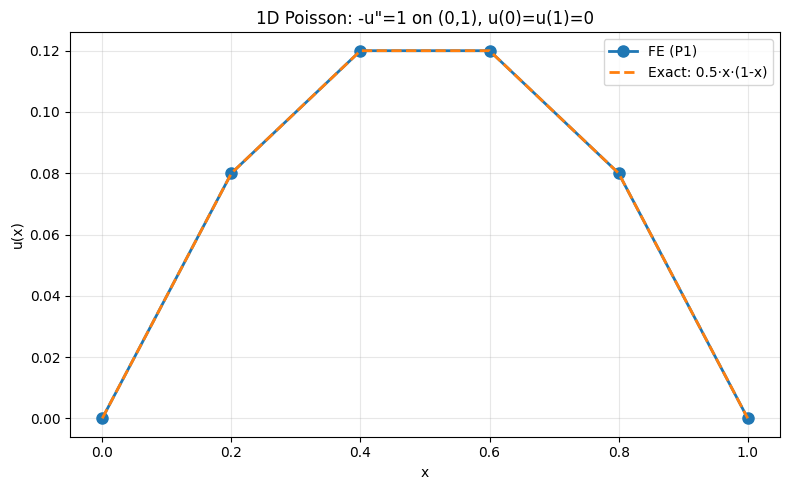

In [23]:
# Exact solution and error analysis
u_exact = 0.5 * x * (1 - x)
err_inf = np.max(np.abs(u - u_exact))
h = 1.0 / n_intervals  # mesh size
print(f"Mesh size h: {h:.3f}")
print(f"Infinity-norm error: {err_inf:.6f}")

# Plot solution comparison
plt.figure(figsize=(8,5))
plt.plot(x, u, marker='o', markersize=8, label='FE (P1)', linewidth=2)

# High-resolution analytical solution for smooth plotting
x_fine = np.linspace(0, 1, 200)
u_exact_fine = 0.5 * x_fine * (1 - x_fine)
plt.plot(x_fine, u_exact_fine, linestyle='--', label='Exact: 0.5·x·(1-x)', linewidth=2)

plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('1D Poisson: -u"=1 on (0,1), u(0)=u(1)=0')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiments
- Change `refine` and observe the error decrease.
- Replace the RHS with a function by defining a custom load form.
- Try nonzero Dirichlet data by modifying the condensation step.